In [7]:
from devito import *

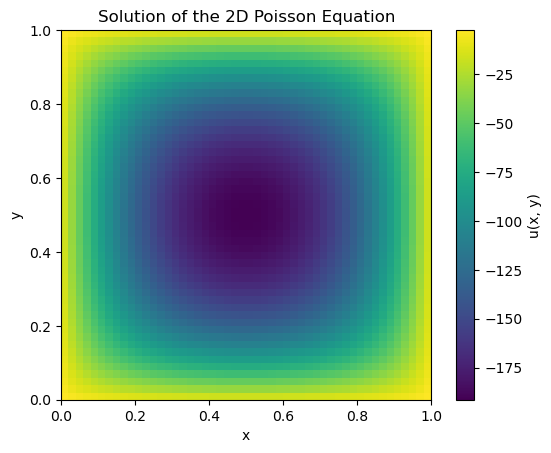

In [197]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt
import imageio

n = 50  
h = 1.0 / (n + 1)  


def source_term(x, y):
    return np.ones_like(x)  

x = np.linspace(h, 1-h, n)
y = np.linspace(h, 1-h, n)
X, Y = np.meshgrid(x, y)
f = source_term(X, Y).flatten()

main_diag = -4 * np.ones(n * n)
off_diag = np.ones(n * n)

for i in range(1, n):
    off_diag[i * n - 1] = 0

diagonals = [main_diag, off_diag, off_diag, np.ones(n * n), np.ones(n * n)]
offsets = [0, -1, 1, -n, n]

A = diags(diagonals, offsets, shape=(n * n, n * n)).tocsc()


u = spsolve(A, f)


U = u.reshape((n, n))

plt.imshow(U, extent=(0, 1, 0, 1), origin='lower', cmap='viridis')
plt.colorbar(label='u(x, y)')
plt.title('Solution of the 2D Poisson Equation')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

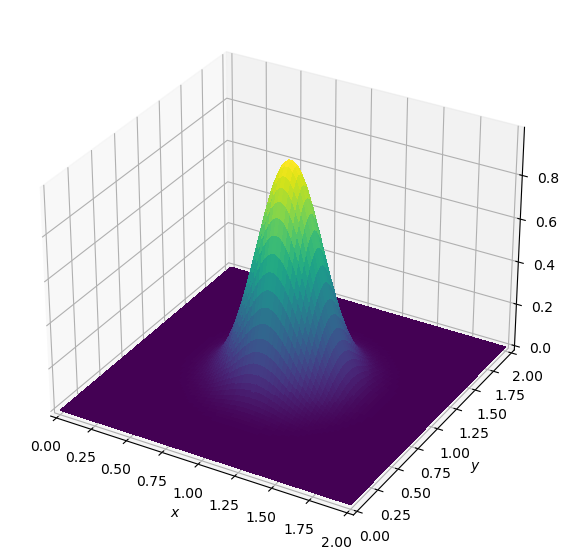

In [8]:
from examples.cfd import  plot_field
import numpy as np

def init_smooth(field, dx, dy):
    nx, ny = field.shape
    x = np.linspace(0, (nx-1)*dx, nx)
    y = np.linspace(0, (ny-1)*dy, ny)
    X, Y = np.meshgrid(x, y, indexing='ij')
    
    # 使用高斯分布初始化平滑场
    sigma = 0.2
    field[:] = np.exp(-((X-nx*dx/2)**2 + (Y-ny*dy/2)**2) / (2*sigma**2))
    
nt = 100  # Number of timesteps
dt = 0.01  # Timestep size (sigma=0.2)
c = 1  # Value for c

# Then we create a grid and our function
grid = Grid(shape=(81, 81), extent=(2., 2.))
u = TimeFunction(name='u', grid=grid,save = nt,time_order = 2, space_order = 2)

# We can now set the initial condition and plot it

init_smooth(field=u.data[0], dx=grid.spacing[0], dy=grid.spacing[1])


plot_field(u.data[0])

In [9]:
eq = Eq(u.dt + c*u.dxl + c*u.dyl)
stencil = solve(eq, u.forward)
update = Eq(u.forward, stencil)
update

Eq(u(time + dt, x, y), dt*(-Derivative(u(time, x, y), x) - Derivative(u(time, x, y), y) + u(time, x, y)/dt))

Operator `Kernel` ran in 0.01 s


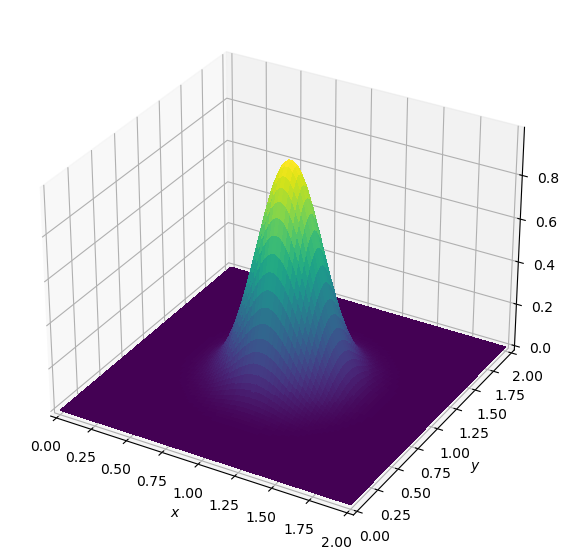

In [10]:
op = Operator(update)
summary = op.apply(dt = dt, time_M =nt-2)
plot_field(u.data[0])

In [11]:
u.data[0]

Data([[7.4046940e-12, 1.3833790e-11, 2.5444234e-11, ..., 4.6073555e-11,
       2.5444234e-11, 1.3833790e-11],
      [1.3833790e-11, 2.5844922e-11, 4.7536086e-11, ..., 8.6076736e-11,
       4.7536086e-11, 2.5844922e-11],
      [2.5444234e-11, 4.7536086e-11, 8.7432249e-11, ..., 1.5831934e-10,
       8.7432249e-11, 4.7536086e-11],
      ...,
      [4.6073555e-11, 8.6076736e-11, 1.5831934e-10, ..., 2.8667932e-10,
       1.5831934e-10, 8.6076736e-11],
      [2.5444234e-11, 4.7536086e-11, 8.7432249e-11, ..., 1.5831934e-10,
       8.7432249e-11, 4.7536086e-11],
      [1.3833790e-11, 2.5844922e-11, 4.7536086e-11, ..., 8.6076736e-11,
       4.7536086e-11, 2.5844922e-11]], dtype=float32)

In [211]:
filenames = []
for i in range(100):
    
    plt.imshow(u.data[i], extent=(0, 2, 0, 2), cmap='viridis')
    plt.colorbar(label='u')
    plt.title(f'Wave Equation Solution at t={i*0.01:.2f}')
    filename = f'_tmp{i}.png'
    filenames.append(filename)
    plt.savefig(filename)
    plt.close()

# 创建gif
with imageio.get_writer('wave_equation.gif', mode='I', duration=0.1) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

# 删除临时文件
import os
for filename in filenames:
    os.remove(filename)

print("Animation saved as wave_equation.gif")

/var/folders/cj/7vpbxq116nlcmkbxd8s_svqm0000gn/T/ipykernel_94203/4246058407.py:15: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


Animation saved as wave_equation.gif


torch.Size([1, 1, 32, 32])


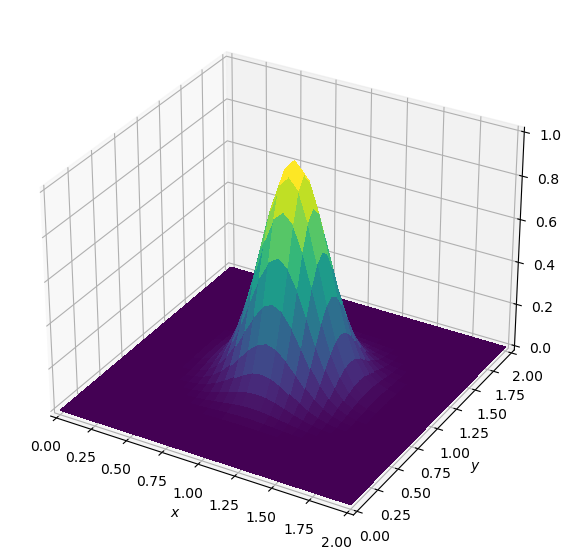

In [5]:
from devito import *
from AI4Advection import AI4Advection
from examples.cfd import  plot_field
import numpy as np
import torch
def init_smooth(field, dx, dy):
    nx, ny = field.shape
    x = np.linspace(0, (nx-1)*dx, nx)
    y = np.linspace(0, (ny-1)*dy, ny)
    X, Y = np.meshgrid(x, y, indexing='ij')
    
    # 使用高斯分布初始化平滑场
    sigma = 0.2
    field[:] = np.exp(-((X-nx*dx/2)**2 + (Y-ny*dy/2)**2) / (2*sigma**2))
    
nt = 100  # Number of timesteps
dt = 0.01  # Timestep size (sigma=0.2)
nx = 32
ny = 32
length = 2.
c = 1  # Value for c

# Then we create a grid and our function
grid = Grid(shape=(nx, ny), extent=(length, length))
u = TimeFunction(name='u', grid=grid,save = nt,time_order = 2, space_order = 2)
# We can now set the initial condition and plot it
init_smooth(field=u.data[0], dx=grid.spacing[0], dy=grid.spacing[1])
u_tensor = torch.tensor(u.data[0], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
torch.save(u_tensor,'./advection_equation_result/AD0')
print(u_tensor.shape)
plot_field(u.data[0])
model = AI4Advection(u = u_tensor, dx = length/nx, dy = length/ny, cx =1, cy = 1, nx = nx, ny = ny,dt = dt)


In [2]:
model.forward()

torch.Size([1, 1, 16, 16])
torch.Size([1, 1, 8, 8])
torch.Size([1, 1, 4, 4])
torch.Size([1, 1, 16, 16])
torch.Size([1, 1, 8, 8])
torch.Size([1, 1, 4, 4])
torch.Size([1, 1, 16, 16])
torch.Size([1, 1, 8, 8])
torch.Size([1, 1, 4, 4])
torch.Size([1, 1, 16, 16])
torch.Size([1, 1, 8, 8])
torch.Size([1, 1, 4, 4])
torch.Size([1, 1, 16, 16])
torch.Size([1, 1, 8, 8])
torch.Size([1, 1, 4, 4])
torch.Size([1, 1, 16, 16])
torch.Size([1, 1, 8, 8])
torch.Size([1, 1, 4, 4])
torch.Size([1, 1, 16, 16])
torch.Size([1, 1, 8, 8])
torch.Size([1, 1, 4, 4])
torch.Size([1, 1, 16, 16])
torch.Size([1, 1, 8, 8])
torch.Size([1, 1, 4, 4])
torch.Size([1, 1, 16, 16])
torch.Size([1, 1, 8, 8])
torch.Size([1, 1, 4, 4])
torch.Size([1, 1, 16, 16])
torch.Size([1, 1, 8, 8])
torch.Size([1, 1, 4, 4])


tensor([[[[0.1571, 0.1383, 0.1393,  ..., 0.1391, 0.1376, 0.1242],
          [0.1383, 0.1226, 0.1239,  ..., 0.1241, 0.1232, 0.1119],
          [0.1393, 0.1239, 0.1252,  ..., 0.1253, 0.1245, 0.1134],
          ...,
          [0.1391, 0.1241, 0.1253,  ..., 0.1254, 0.1246, 0.1133],
          [0.1376, 0.1232, 0.1245,  ..., 0.1246, 0.1238, 0.1129],
          [0.1242, 0.1119, 0.1134,  ..., 0.1133, 0.1129, 0.1035]]]],
       grad_fn=<AddBackward0>)

In [3]:
for i in range(1,nt):
    model = AI4Advection(u = u_tensor, dx = length/nx, dy = length/ny, cx =1, cy = 1, nx = nx, ny = ny,dt = dt)
    result = model.forward()
    u_tensor = result
    torch.save(u_tensor,f'./advection_equation_result/AD{i}')

torch.Size([1, 1, 16, 16])
torch.Size([1, 1, 8, 8])
torch.Size([1, 1, 4, 4])
torch.Size([1, 1, 16, 16])
torch.Size([1, 1, 8, 8])
torch.Size([1, 1, 4, 4])
torch.Size([1, 1, 16, 16])
torch.Size([1, 1, 8, 8])
torch.Size([1, 1, 4, 4])
torch.Size([1, 1, 16, 16])
torch.Size([1, 1, 8, 8])
torch.Size([1, 1, 4, 4])
torch.Size([1, 1, 16, 16])
torch.Size([1, 1, 8, 8])
torch.Size([1, 1, 4, 4])
torch.Size([1, 1, 16, 16])
torch.Size([1, 1, 8, 8])
torch.Size([1, 1, 4, 4])
torch.Size([1, 1, 16, 16])
torch.Size([1, 1, 8, 8])
torch.Size([1, 1, 4, 4])
torch.Size([1, 1, 16, 16])
torch.Size([1, 1, 8, 8])
torch.Size([1, 1, 4, 4])
torch.Size([1, 1, 16, 16])
torch.Size([1, 1, 8, 8])
torch.Size([1, 1, 4, 4])
torch.Size([1, 1, 16, 16])
torch.Size([1, 1, 8, 8])
torch.Size([1, 1, 4, 4])
torch.Size([1, 1, 16, 16])
torch.Size([1, 1, 8, 8])
torch.Size([1, 1, 4, 4])
torch.Size([1, 1, 16, 16])
torch.Size([1, 1, 8, 8])
torch.Size([1, 1, 4, 4])
torch.Size([1, 1, 16, 16])
torch.Size([1, 1, 8, 8])
torch.Size([1, 1, 4, 4])

torch.Size([1, 1, 16, 16])
torch.Size([1, 1, 8, 8])
torch.Size([1, 1, 4, 4])
torch.Size([1, 1, 16, 16])
torch.Size([1, 1, 8, 8])
torch.Size([1, 1, 4, 4])
torch.Size([1, 1, 16, 16])
torch.Size([1, 1, 8, 8])
torch.Size([1, 1, 4, 4])
torch.Size([1, 1, 16, 16])
torch.Size([1, 1, 8, 8])
torch.Size([1, 1, 4, 4])
torch.Size([1, 1, 16, 16])
torch.Size([1, 1, 8, 8])
torch.Size([1, 1, 4, 4])
torch.Size([1, 1, 16, 16])
torch.Size([1, 1, 8, 8])
torch.Size([1, 1, 4, 4])
torch.Size([1, 1, 16, 16])
torch.Size([1, 1, 8, 8])
torch.Size([1, 1, 4, 4])
torch.Size([1, 1, 16, 16])
torch.Size([1, 1, 8, 8])
torch.Size([1, 1, 4, 4])
torch.Size([1, 1, 16, 16])
torch.Size([1, 1, 8, 8])
torch.Size([1, 1, 4, 4])
torch.Size([1, 1, 16, 16])
torch.Size([1, 1, 8, 8])
torch.Size([1, 1, 4, 4])
torch.Size([1, 1, 16, 16])
torch.Size([1, 1, 8, 8])
torch.Size([1, 1, 4, 4])
torch.Size([1, 1, 16, 16])
torch.Size([1, 1, 8, 8])
torch.Size([1, 1, 4, 4])
torch.Size([1, 1, 16, 16])
torch.Size([1, 1, 8, 8])
torch.Size([1, 1, 4, 4])

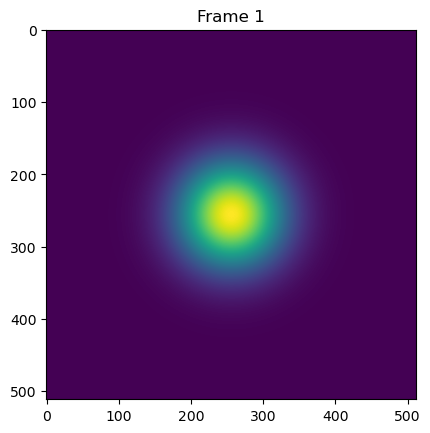

In [31]:
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# 定义读取文件夹中所有NumPy数组的函数
def load_numpy_arrays_from_folder(folder_path):
    arrays = []
    for filename in sorted(os.listdir(folder_path)):
        if filename.endswith('.npy'):
            file_path = os.path.join(folder_path, filename)
            arrays.append(np.load(file_path))
    return arrays

# 定义动画显示函数
def animate_arrays(arrays):
    fig, ax = plt.subplots()
    def update(frame):
        ax.clear()
        ax.imshow(arrays[frame], cmap='viridis')
        ax.set_title(f'Frame {frame + 1}')
    anim = FuncAnimation(fig, update, frames=len(arrays), interval=200)
    return anim

# 加载数组并显示动画
folder_path = './advection_equation_result'  # 替换为实际的文件夹路径
arrays = load_numpy_arrays_from_folder(folder_path)
anim = animate_arrays(arrays)
HTML(anim.to_jshtml())